# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000) 
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [4]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(9000, 3073)
(9000,)
(1000, 3073)
(1000,)


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)

assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
# print(probs)
print(linear_classifer.cross_entropy_loss(probs, 1))

5.006760443547122


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
#print(loss, grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 898.952293
Epoch 1, loss: 816.194774
Epoch 2, loss: 891.429815
Epoch 3, loss: 814.898675
Epoch 4, loss: 929.844823
Epoch 5, loss: 865.632208
Epoch 6, loss: 931.091506
Epoch 7, loss: 1013.350902
Epoch 8, loss: 914.784839
Epoch 9, loss: 813.284659


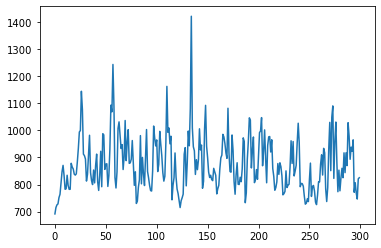

In [13]:
# let's look at the loss history!
plt.plot(loss_history)

In [14]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.15
Epoch 0, loss: 944.903286
Epoch 1, loss: 749.665666
Epoch 2, loss: 998.808337
Epoch 3, loss: 856.117335
Epoch 4, loss: 967.788841
Epoch 5, loss: 776.844931
Epoch 6, loss: 715.805885
Epoch 7, loss: 886.629020
Epoch 8, loss: 825.677675
Epoch 9, loss: 841.382084
Epoch 10, loss: 829.201472
Epoch 11, loss: 869.654826
Epoch 12, loss: 948.022522
Epoch 13, loss: 1005.674605
Epoch 14, loss: 861.247777
Epoch 15, loss: 782.456888
Epoch 16, loss: 902.937625
Epoch 17, loss: 757.488625
Epoch 18, loss: 892.230149
Epoch 19, loss: 822.012115
Epoch 20, loss: 781.078026
Epoch 21, loss: 934.127674
Epoch 22, loss: 789.135894
Epoch 23, loss: 824.718938
Epoch 24, loss: 704.912313
Epoch 25, loss: 915.871542
Epoch 26, loss: 911.931770
Epoch 27, loss: 860.948069
Epoch 28, loss: 978.683723
Epoch 29, loss: 885.967114
Epoch 30, loss: 723.218318
Epoch 31, loss: 1044.913209
Epoch 32, loss: 866.798825
Epoch 33, loss: 843.543127
Epoch 34, loss: 891.900430
Epoch 35, loss: 862.928630
Epoch 36, loss: 806.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [16]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, batch_size, learning_rate, reg_strength, num_epochs)
        prediction = classifier.predict(val_X)
        accuracy = multiclass_accuracy(prediction, val_y)
        
        if best_val_accuracy is None or best_val_accuracy > accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 768.906505
Epoch 1, loss: 954.563411
Epoch 2, loss: 763.110357
Epoch 3, loss: 1002.956426
Epoch 4, loss: 800.698880
Epoch 5, loss: 809.994932
Epoch 6, loss: 750.172779
Epoch 7, loss: 973.093489
Epoch 8, loss: 987.105045
Epoch 9, loss: 830.856709
Epoch 10, loss: 721.854666
Epoch 11, loss: 842.277444
Epoch 12, loss: 824.164629
Epoch 13, loss: 709.523555
Epoch 14, loss: 745.123840
Epoch 15, loss: 710.812403
Epoch 16, loss: 880.171574
Epoch 17, loss: 764.996568
Epoch 18, loss: 789.645923
Epoch 19, loss: 740.399225
Epoch 20, loss: 992.582624
Epoch 21, loss: 866.355663
Epoch 22, loss: 820.975827
Epoch 23, loss: 859.378077
Epoch 24, loss: 704.085663
Epoch 25, loss: 826.750966
Epoch 26, loss: 786.602227
Epoch 27, loss: 843.714436
Epoch 28, loss: 1032.315734
Epoch 29, loss: 922.716496
Epoch 30, loss: 823.422783
Epoch 31, loss: 912.074642
Epoch 32, loss: 1070.285407
Epoch 33, loss: 726.430931
Epoch 34, loss: 884.843522
Epoch 35, loss: 838.977818
Epoch 36, loss: 685.170690
Epoch 37

Epoch 101, loss: 753.087070
Epoch 102, loss: 781.804239
Epoch 103, loss: 703.357949
Epoch 104, loss: 660.613343
Epoch 105, loss: 791.255536
Epoch 106, loss: 780.111248
Epoch 107, loss: 712.317217
Epoch 108, loss: 805.446407
Epoch 109, loss: 750.942991
Epoch 110, loss: 872.719314
Epoch 111, loss: 657.541591
Epoch 112, loss: 658.245073
Epoch 113, loss: 766.145029
Epoch 114, loss: 857.111747
Epoch 115, loss: 730.502999
Epoch 116, loss: 799.024741
Epoch 117, loss: 819.757243
Epoch 118, loss: 643.693487
Epoch 119, loss: 751.540821
Epoch 120, loss: 734.727880
Epoch 121, loss: 652.618418
Epoch 122, loss: 906.631054
Epoch 123, loss: 879.061715
Epoch 124, loss: 722.288506
Epoch 125, loss: 743.453319
Epoch 126, loss: 665.377053
Epoch 127, loss: 686.805969
Epoch 128, loss: 776.042855
Epoch 129, loss: 882.510534
Epoch 130, loss: 772.290162
Epoch 131, loss: 699.329074
Epoch 132, loss: 656.047847
Epoch 133, loss: 746.495625
Epoch 134, loss: 659.484019
Epoch 135, loss: 635.950916
Epoch 136, loss: 721

Epoch 198, loss: 716.686606
Epoch 199, loss: 685.118531
Epoch 0, loss: 686.253848
Epoch 1, loss: 680.222149
Epoch 2, loss: 675.740729
Epoch 3, loss: 673.459591
Epoch 4, loss: 669.648610
Epoch 5, loss: 663.484288
Epoch 6, loss: 671.467003
Epoch 7, loss: 664.394169
Epoch 8, loss: 653.554259
Epoch 9, loss: 655.479216
Epoch 10, loss: 647.894033
Epoch 11, loss: 647.759472
Epoch 12, loss: 650.846110
Epoch 13, loss: 643.718464
Epoch 14, loss: 642.208624
Epoch 15, loss: 654.346629
Epoch 16, loss: 647.964524
Epoch 17, loss: 636.542911
Epoch 18, loss: 641.393752
Epoch 19, loss: 644.301866
Epoch 20, loss: 643.074916
Epoch 21, loss: 647.692286
Epoch 22, loss: 656.884131
Epoch 23, loss: 643.095989
Epoch 24, loss: 648.676545
Epoch 25, loss: 638.879637
Epoch 26, loss: 632.742371
Epoch 27, loss: 645.716522
Epoch 28, loss: 644.967282
Epoch 29, loss: 639.364280
Epoch 30, loss: 622.740475
Epoch 31, loss: 649.600791
Epoch 32, loss: 645.839981
Epoch 33, loss: 632.332536
Epoch 34, loss: 639.327714
Epoch 35,

Epoch 99, loss: 618.321148
Epoch 100, loss: 625.916113
Epoch 101, loss: 616.160981
Epoch 102, loss: 613.948897
Epoch 103, loss: 625.019686
Epoch 104, loss: 643.314041
Epoch 105, loss: 609.040716
Epoch 106, loss: 627.915701
Epoch 107, loss: 636.497485
Epoch 108, loss: 625.562682
Epoch 109, loss: 612.797913
Epoch 110, loss: 626.610781
Epoch 111, loss: 627.270061
Epoch 112, loss: 630.984930
Epoch 113, loss: 623.585463
Epoch 114, loss: 621.698360
Epoch 115, loss: 633.149653
Epoch 116, loss: 610.511901
Epoch 117, loss: 617.931143
Epoch 118, loss: 629.423014
Epoch 119, loss: 628.210604
Epoch 120, loss: 636.559032
Epoch 121, loss: 628.896830
Epoch 122, loss: 606.703066
Epoch 123, loss: 617.005932
Epoch 124, loss: 619.843325
Epoch 125, loss: 633.275522
Epoch 126, loss: 623.896357
Epoch 127, loss: 623.016229
Epoch 128, loss: 627.201453
Epoch 129, loss: 613.053873
Epoch 130, loss: 609.081117
Epoch 131, loss: 621.728859
Epoch 132, loss: 626.062201
Epoch 133, loss: 621.405017
Epoch 134, loss: 635.

Epoch 196, loss: 624.186709
Epoch 197, loss: 616.151276
Epoch 198, loss: 610.520651
Epoch 199, loss: 633.933314
Epoch 0, loss: 690.234364
Epoch 1, loss: 690.102874
Epoch 2, loss: 689.099249
Epoch 3, loss: 687.250700
Epoch 4, loss: 686.581931
Epoch 5, loss: 688.940125
Epoch 6, loss: 685.712480
Epoch 7, loss: 684.770960
Epoch 8, loss: 685.549863
Epoch 9, loss: 683.229423
Epoch 10, loss: 682.140335
Epoch 11, loss: 685.133695
Epoch 12, loss: 683.039200
Epoch 13, loss: 685.536440
Epoch 14, loss: 679.774652
Epoch 15, loss: 683.088802
Epoch 16, loss: 676.959781
Epoch 17, loss: 677.081985
Epoch 18, loss: 678.306506
Epoch 19, loss: 674.851815
Epoch 20, loss: 676.814423
Epoch 21, loss: 676.769674
Epoch 22, loss: 675.786818
Epoch 23, loss: 678.640288
Epoch 24, loss: 672.771400
Epoch 25, loss: 672.833346
Epoch 26, loss: 671.584521
Epoch 27, loss: 677.417657
Epoch 28, loss: 673.946594
Epoch 29, loss: 671.804128
Epoch 30, loss: 669.725249
Epoch 31, loss: 676.937247
Epoch 32, loss: 675.736955
Epoch 3

Epoch 97, loss: 638.354315
Epoch 98, loss: 659.724624
Epoch 99, loss: 653.837858
Epoch 100, loss: 647.962096
Epoch 101, loss: 649.645937
Epoch 102, loss: 648.136539
Epoch 103, loss: 655.828154
Epoch 104, loss: 662.747542
Epoch 105, loss: 656.343591
Epoch 106, loss: 656.504888
Epoch 107, loss: 655.452391
Epoch 108, loss: 653.188140
Epoch 109, loss: 650.420805
Epoch 110, loss: 648.576637
Epoch 111, loss: 646.734932
Epoch 112, loss: 655.102057
Epoch 113, loss: 652.527757
Epoch 114, loss: 645.333763
Epoch 115, loss: 646.908355
Epoch 116, loss: 649.089059
Epoch 117, loss: 657.431082
Epoch 118, loss: 648.653677
Epoch 119, loss: 651.759426
Epoch 120, loss: 651.983122
Epoch 121, loss: 659.296193
Epoch 122, loss: 654.278165
Epoch 123, loss: 654.146252
Epoch 124, loss: 648.600348
Epoch 125, loss: 650.816517
Epoch 126, loss: 650.347602
Epoch 127, loss: 644.085152
Epoch 128, loss: 651.320704
Epoch 129, loss: 645.329509
Epoch 130, loss: 653.288827
Epoch 131, loss: 650.073832
Epoch 132, loss: 649.48

Epoch 194, loss: 640.118842
Epoch 195, loss: 664.321458
Epoch 196, loss: 629.641815
Epoch 197, loss: 637.658313
Epoch 198, loss: 644.958783
Epoch 199, loss: 652.478484
best validation accuracy achieved: 0.187000


# Какой же точности мы добились на тестовых данных?

In [17]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.182000
